<a href="https://colab.research.google.com/github/krymbeaulieu/cmpe258-group3-style-transfer/blob/main/CMPE_258_Project_G3_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/krymbeaulieu/cmpe258-group3-style-transfer.git
%cd cmpe258-group3-style-transfer
!ls

Cloning into 'cmpe258-group3-style-transfer'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 69 (delta 31), reused 23 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 19.74 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/cmpe258-group3-style-transfer
CMPE_258_Project_G3_Lee.ipynb  evals.py		      losses.py  README.md
data_feat_load.py	       krystle_scratch.ipynb  models.py  train.py


In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
%%writefile evals.py
import torch
import lpips

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_lpips_model = lpips.LPIPS(net='vgg').to(device).eval()

def get_lpips(img1, img2):
    """
    Computes LPIPS perceptual distance between two images.
    Both img1 and img2 must be [1, 3, H, W] tensors in [0,1].
    """
    with torch.no_grad():
        dist = lpips_model(img1, img2)
    return dist.item()



Overwriting evals.py


In [ ]:
import os
import time
import glob, random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import lpips
import torch.optim as optim

In [ ]:
import losses as loss
import data_feat_load as dfl
import train
import evals

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 238MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
WIKIART_PATH = "/content/drive/MyDrive/CMPE258/project/archive"
COCO_PATH = "/content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017"

print("WikiArt:", os.path.exists(WIKIART_PATH))
print("COCO:", os.path.exists(COCO_PATH))


WikiArt: True
COCO: True


In [ ]:
coco_images = glob.glob(f"{COCO_PATH}/*.jpg")
print("Found", len(coco_images), "COCO images")

# wikiart_images = glob.glob(f"{WIKIART_PATH}/**/*.jpg", recursive=True)
# print("Found", len(wikiart_images), "WikiArt images")

# content_img = random.choice(coco_images)
# style_img = random.choice(wikiart_images)

# print("Content image:", content_img)
# print("Style image:", style_img)


Found 123404 COCO images


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 512

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])




In [ ]:
def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

In [ ]:
vgg = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()

# Extract intermediate layers for content & style
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 215MB/s]


In [ ]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [ ]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

In [ ]:
def style_transfer(content, style, model, content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss (MSE)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
            style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
            layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            target.clamp_(0, 1)

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


In [ ]:
# Initialize once (so we don’t reload model each time)
lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

def get_lpips(img1, img2):
    """
    Compute LPIPS (Learned Perceptual Image Patch Similarity) distance
    between two images using a pretrained VGG network.

    Args:
        img1 (torch.Tensor): First image tensor [1, 3, H, W], normalized to [0,1].
        img2 (torch.Tensor): Second image tensor [1, 3, H, W], normalized to [0,1].

    Returns:
        float: LPIPS distance (lower = more perceptually similar)
    """
    with torch.no_grad():
        dist = lpips_model(img1, img2)
    return dist.item()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000160675.jpg


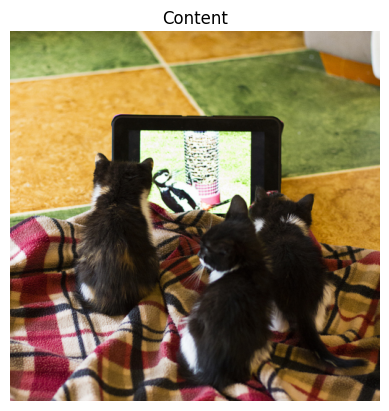

In [ ]:
content_img = f"{COCO_PATH}/000000160675.jpg"
# content_img = random.choice(coco_images)

content = load_image(content_img)
imshow(content, "Content")
print("Content image:", content_img)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/constantine-maleas_olympia.jpg


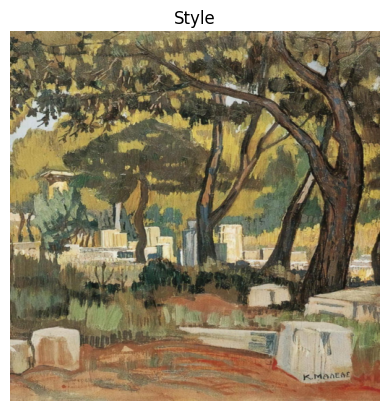

In [ ]:
style_img= f"{WIKIART_PATH}/Post_Impressionism/constantine-maleas_olympia.jpg"
# style_img = random.choice(wikiart_images)
style = load_image(style_img)
imshow(style, "Style")
print("Style image:", style_img)


In [ ]:

start = time.time()
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=1000)
end = time.time()
print(f"time taken: {end-start:.03f}s")

Step [0/5000]  Total Loss: 11066583.00
Step [100/5000]  Total Loss: 101662.63
Step [200/5000]  Total Loss: 53521.80
Step [300/5000]  Total Loss: 38830.22
Step [400/5000]  Total Loss: 32809.49
Step [500/5000]  Total Loss: 27845.23
Step [600/5000]  Total Loss: 25137.96
Step [700/5000]  Total Loss: 22820.70
Step [800/5000]  Total Loss: 24048.60
Step [900/5000]  Total Loss: 19428.57
Step [1000/5000]  Total Loss: 19528.11
Step [1100/5000]  Total Loss: 21779.65
Step [1200/5000]  Total Loss: 28192.81
Step [1300/5000]  Total Loss: 15412.21
Step [1400/5000]  Total Loss: 16072.40
Step [1500/5000]  Total Loss: 16704.32
Step [1600/5000]  Total Loss: 15252.75
Step [1700/5000]  Total Loss: 29725.14
Step [1800/5000]  Total Loss: 13501.67
Step [1900/5000]  Total Loss: 13406.73
Step [2000/5000]  Total Loss: 23339.74
Step [2100/5000]  Total Loss: 12093.67
Step [2200/5000]  Total Loss: 13333.61
Step [2300/5000]  Total Loss: 16279.78
Step [2400/5000]  Total Loss: 11409.46
Step [2500/5000]  Total Loss: 109

Step [0/5000]  Total Loss: 11066583.00
Step [100/5000]  Total Loss: 101662.63
Step [200/5000]  Total Loss: 53521.80
Step [300/5000]  Total Loss: 38830.22
Step [400/5000]  Total Loss: 32809.49
Step [500/5000]  Total Loss: 27845.23
Step [600/5000]  Total Loss: 25137.96
Step [700/5000]  Total Loss: 22820.70
Step [800/5000]  Total Loss: 24048.60
Step [900/5000]  Total Loss: 19428.57
Step [1000/5000]  Total Loss: 19528.11
Step [1100/5000]  Total Loss: 21779.65
Step [1200/5000]  Total Loss: 28192.81
Step [1300/5000]  Total Loss: 15412.21
Step [1400/5000]  Total Loss: 16072.40
Step [1500/5000]  Total Loss: 16704.32
Step [1600/5000]  Total Loss: 15252.75
Step [1700/5000]  Total Loss: 29725.14
Step [1800/5000]  Total Loss: 13501.67
Step [1900/5000]  Total Loss: 13406.73
Step [2000/5000]  Total Loss: 23339.74
Step [2100/5000]  Total Loss: 12093.67
Step [2200/5000]  Total Loss: 13333.61
Step [2300/5000]  Total Loss: 16279.78
Step [2400/5000]  Total Loss: 11409.46
Step [2500/5000]  Total Loss: 109

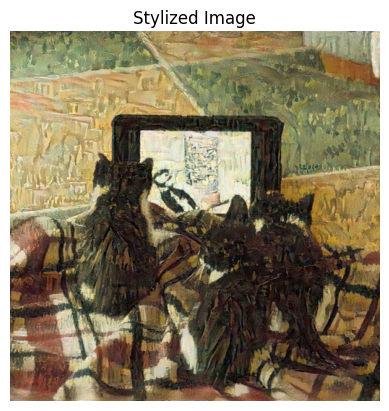

In [ ]:
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
imshow(output, "Stylized Image")

In [ ]:
# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='vgg').to(device)

# Compute perceptual distance between content and stylized output
lpips_distance = lpips_model(content, output)
print(f"LPIPS (content-output): {lpips_distance.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS (content-output): 0.5249


Post-Impressionism

NameError: name 'content1' is not defined

Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000115526.jpg


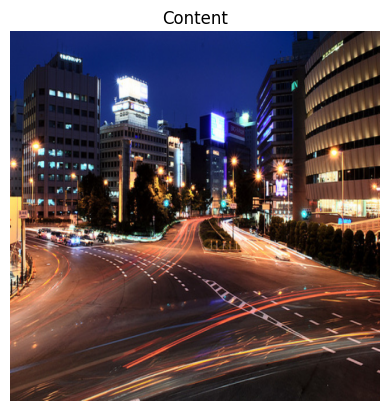

In [ ]:
content_img1 = f"{COCO_PATH}/000000115526.jpg"
content1 = load_image(content_img1)
imshow(content1, "Content")
print("Content image:", content_img1)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg


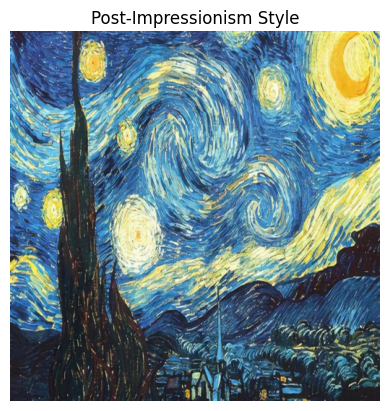

In [ ]:
imp_style_img= f"{WIKIART_PATH}/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg"
imp_style = load_image(imp_style_img)
imshow(imp_style, "Post-Impressionism Style")
print("Style image:", imp_style_img)


Step [0/5000]  Total Loss: 52265620.00
Step [100/5000]  Total Loss: 1049155.25
Step [200/5000]  Total Loss: 492953.69
Step [300/5000]  Total Loss: 283504.31
Step [400/5000]  Total Loss: 179051.61
Step [500/5000]  Total Loss: 126038.20
Step [600/5000]  Total Loss: 98604.45
Step [700/5000]  Total Loss: 83341.34
Step [800/5000]  Total Loss: 73872.66
Step [900/5000]  Total Loss: 67301.91
Step [1000/5000]  Total Loss: 62329.48
Step [1100/5000]  Total Loss: 58344.69
Step [1200/5000]  Total Loss: 55009.50
Step [1300/5000]  Total Loss: 52149.69
Step [1400/5000]  Total Loss: 49655.85
Step [1500/5000]  Total Loss: 47440.13
Step [1600/5000]  Total Loss: 45447.88
Step [1700/5000]  Total Loss: 43659.76
Step [1800/5000]  Total Loss: 42159.69
Step [1900/5000]  Total Loss: 41014.45
Step [2000/5000]  Total Loss: 46849.66
Step [2100/5000]  Total Loss: 38153.38
Step [2200/5000]  Total Loss: 37039.06
Step [2300/5000]  Total Loss: 35540.66
Step [2400/5000]  Total Loss: 34495.73
Step [2500/5000]  Total Loss

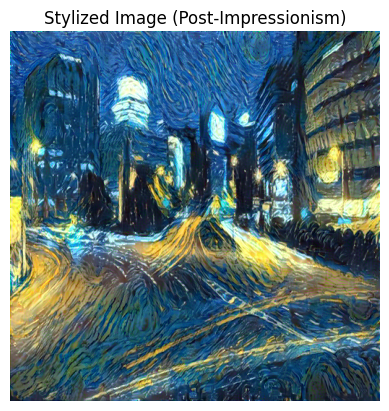

In [ ]:
impressionism_output = style_transfer(content1, imp_style, vgg, steps=5000, stop_threshold=1000)
imshow(impressionism_output, "Stylized Image (Post-Impressionism)")

Fauvism Style image: /content/drive/MyDrive/CMPE258/project/archive/Fauvism/andre-derain_charing-cross-bridge.jpg


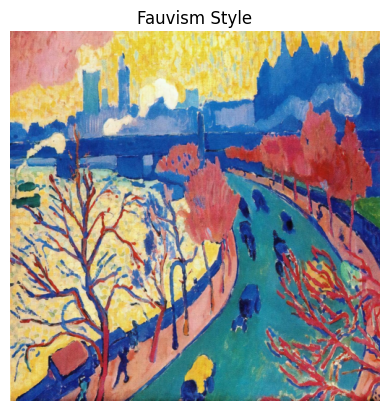

In [ ]:
fauvism_style_img= f"{WIKIART_PATH}/Fauvism/andre-derain_charing-cross-bridge.jpg"
fauvism_style = load_image(fauvism_style_img)
imshow(fauvism_style, "Fauvism Style")
print("Fauvism Style image:", fauvism_style_img)



Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000417882.jpg


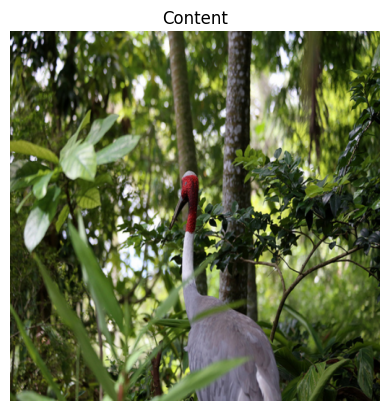

In [ ]:
# content_img2 = f"{COCO_PATH}/000000067432.jpg
content_img2 = random.choice(coco_images)
content2 = load_image(content_img2)
imshow(content2, "Content")
print("Content image:", content_img2)



Step [0/10000]  Total Loss: 59767704.00
Step [100/10000]  Total Loss: 1431495.88
Step [200/10000]  Total Loss: 801767.69
Step [300/10000]  Total Loss: 591863.00
Step [400/10000]  Total Loss: 467216.91
Step [500/10000]  Total Loss: 385735.88
Step [600/10000]  Total Loss: 329124.59
Step [700/10000]  Total Loss: 287136.00
Step [800/10000]  Total Loss: 253887.12
Step [900/10000]  Total Loss: 226799.67
Step [1000/10000]  Total Loss: 204008.42
Step [1100/10000]  Total Loss: 183330.28
Step [1200/10000]  Total Loss: 164517.66
Step [1300/10000]  Total Loss: 148575.22
Step [1400/10000]  Total Loss: 136265.94
Step [1500/10000]  Total Loss: 123031.40
Step [1600/10000]  Total Loss: 113951.31
Step [1700/10000]  Total Loss: 104324.63
Step [1800/10000]  Total Loss: 101507.11
Step [1900/10000]  Total Loss: 91174.84
Step [2000/10000]  Total Loss: 86364.20
Step [2100/10000]  Total Loss: 82054.33
Step [2200/10000]  Total Loss: 82520.33
Step [2300/10000]  Total Loss: 74671.87
Step [2400/10000]  Total Loss:

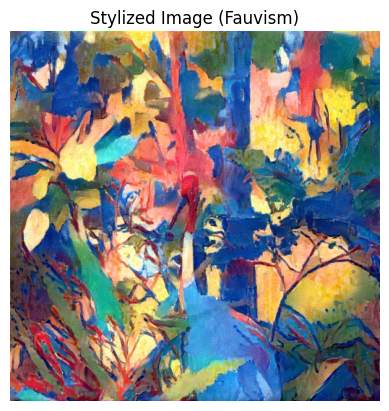

In [ ]:
fauvism_output = style_transfer(content2, fauvism_style, vgg, steps=10000, stop_threshold=1000)
imshow(fauvism_output, "Stylized Image (Fauvism)")

Cubism

Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000002715.jpg


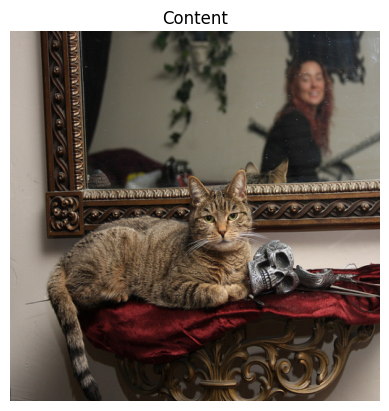

In [ ]:
content_img3 = f"{COCO_PATH}/000000002715.jpg"
content3 = load_image(content_img3)
imshow(content3, "Content")
print("Content image:", content_img3)


Expressionism Style image: /content/drive/MyDrive/CMPE258/project/archive/Expressionism/edvard-munch_the-scream-1910.jpg


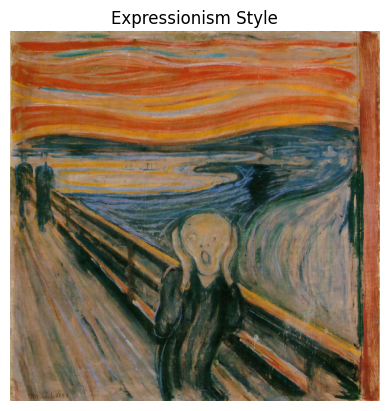

In [ ]:
exp_style_img= f"{WIKIART_PATH}/Expressionism/edvard-munch_the-scream-1910.jpg"
exp_style = load_image(exp_style_img)
imshow(exp_style, "Expressionism Style")
print("Expressionism Style image:", exp_style_img)

Step [0/5000]  Total Loss: 8937495.00
Step [100/5000]  Total Loss: 155259.52
Step [200/5000]  Total Loss: 71864.40
Step [300/5000]  Total Loss: 50079.22
Step [400/5000]  Total Loss: 40733.19
Step [500/5000]  Total Loss: 34601.89
Step [600/5000]  Total Loss: 29894.77
Step [700/5000]  Total Loss: 26579.05
Step [800/5000]  Total Loss: 23972.69
Step [900/5000]  Total Loss: 21114.12
Step [1000/5000]  Total Loss: 19193.11
Step [1100/5000]  Total Loss: 17539.44
Step [1200/5000]  Total Loss: 20237.01
Step [1300/5000]  Total Loss: 14990.26
Step [1400/5000]  Total Loss: 13812.95
Step [1500/5000]  Total Loss: 13728.21
Step [1600/5000]  Total Loss: 16996.30
Step [1700/5000]  Total Loss: 12532.32
Step [1800/5000]  Total Loss: 14306.05
Step [1900/5000]  Total Loss: 11387.68
Step [2000/5000]  Total Loss: 10088.56
Step [2100/5000]  Total Loss: 21897.13
Step [2200/5000]  Total Loss: 9889.05
Step [2300/5000]  Total Loss: 9195.28
Step [2400/5000]  Total Loss: 9053.85
Step [2500/5000]  Total Loss: 9694.46

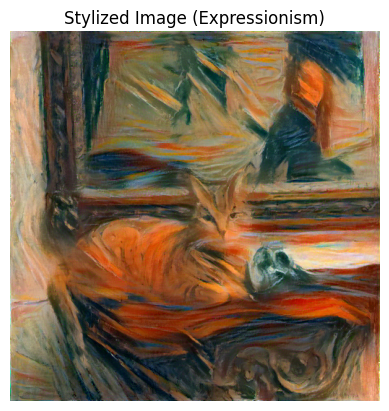

In [ ]:
exp_output = style_transfer(content3, exp_style, vgg, steps=5000, stop_threshold=1000)
imshow(exp_output, "Stylized Image (Expressionism)")

In [ ]:
print("Impressionism LPIPS (before stylizing): ", get_lpips(content1, impressionism_output)) #imp_style
print("Impressionism LPIPS (after stylizing): ", get_lpips(imp_style, impressionism_output)) #imp_style
print("Fauvism LPIPS (before stylizing): ", get_lpips(content2, fauvism_output))
print("Fauvism LPIPS (after stylizing): ", get_lpips(fauvism_style, fauvism_output))
print("Expressionism LPIPS (before stylizing): ", get_lpips(content3, exp_output))
print("Expressionism LPIPS (after stylizing): ", get_lpips(exp_style, exp_output))

Impressionism LPIPS (before stylizing):  0.5857475996017456
Impressionism LPIPS (after stylizing):  0.6205060482025146
Fauvism LPIPS (before stylizing):  0.6565556526184082
Fauvism LPIPS (after stylizing):  0.7375768423080444
Expressionism LPIPS (before stylizing):  0.585140585899353
Expressionism LPIPS (after stylizing):  0.6468297243118286
